# 1. Data Analysis of the Influencers:
# 2. Sentiment Analysis of the Influencers: 


In [34]:
#  TM -Import the Dependencies
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime, timezone
#  TM -import seaborn as sns
from os import path, makedirs # fetch path and makedirs function from os file
import csv # fetch csv file
from glob import glob # fetching glob function only from the glob lib

In [35]:
#  TM -Import keys from the config file
from config import consumer_key, consumer_secret, access_token, access_token_secret

In [36]:
#  TM - Twitter API Keys
# consumer_key = 'Your Key'
# consumer_secret = 'Your Key'
# access_token = 'Your Key'
# access_token_secret = 'Your Key'

In [37]:
# TM - Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [38]:
# TM - Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [39]:
#  TM - Load and read csv file containing the details of the Influencers 
influencer_data_load = "RawData/SentimentInfluencerInputData.csv"
influencer_data_read = pd.read_csv(influencer_data_load)

In [40]:
#  Team version merged.
# TM - for index, row in Influencers_DF.iterrows():
Data_Influencers_DF = influencer_data_read
Not_Found = 0

#  TM - Define variable for holding tweets for influencer

all_tweet_listing = []

print("-----------Start extraction!!!-----------")

for index, row in Data_Influencers_DF.iterrows():
    target_user = row["Twitter_Handle"]
    Genre =  row["Genre"]
    
    try:
        
        # TM -  retrieve top 200 tweets for influencer
        
        public_tweets = api.user_timeline(target_user, count=200, result_type="recent")

        # TM -  write to all_tweet_listing

        for tweet in public_tweets:
            
            Date = datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y').strftime('%m/%d/%Y')

            all_tweet_listing.append({"Influencer":target_user,
                               "Date": Date,
                               "Genre":Genre,
                               "Tweet":tweet["text"]})
    
        user_account = api.get_user(target_user)
        user_geo_enabled = user_account["geo_enabled"]
        if (user_geo_enabled == True):
            Data_Influencers_DF.at[index, "Loc"] = user_account["location"]
        else:
            Data_Influencers_DF.at[index, "Loc"] = 'NA'

        if (user_account["lang"] == 'en'):
            Data_Influencers_DF.at[index, "Lang"] = 'Eng'
        else:
            Data_Influencers_DF.at[index, "Lang"] = 'NA'
        
        Data_Influencers_DF.at[index, "Created On"] = datetime.strptime(user_account['created_at'],'%a %b %d %H:%M:%S %z %Y').strftime('%m/%d/%Y')
        
        Data_Influencers_DF.at[index, "Age Of Account"] = (datetime.now(timezone.utc) - datetime.strptime(user_account['created_at'],'%a %b %d %H:%M:%S %z %Y')).days
        
        
       #  TM -  Data_Influencers_DF.at[index, "Real Name"] = user_real_name
        Data_Influencers_DF.at[index, "Tweets"] = user_account["statuses_count"]
        Data_Influencers_DF.at[index, "Followers"] = user_account["followers_count"]
        Data_Influencers_DF.at[index, "Following"] = user_account["friends_count"]
        Data_Influencers_DF.at[index, "Favorites Count"] = user_account["favourites_count"]
        
              
    
    except tweepy.TweepError as e:
        Not_Found = Not_Found + 1
        print(f"exception for {row['Twitter_Handle']}: {e}")

print("----------- Extraction Complete !!!-----------")        
print(Not_Found)

-----------Start extraction!!!-----------
exception for @ilanusglazer: Not authorized.
exception for @billieelish: Not authorized.
exception for @titoortiz: Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
----------- Extraction Complete !!!-----------
3


In [41]:
# TM - translate dict to a dataframe
tweet_listing_pd = pd.DataFrame.from_dict(all_tweet_listing)

In [42]:
# TM - stats for tweet listing for influencers. PLEASE DON'T REMOVE. Required to quantify digital footprint!
tweet_listing_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68505 entries, 0 to 68504
Data columns (total 4 columns):
Date          68505 non-null object
Genre         68505 non-null object
Influencer    68505 non-null object
Tweet         68505 non-null object
dtypes: object(4)
memory usage: 2.1+ MB


In [43]:
# TM - top 1000 key words from Influencer tweets#SS -to 

Top_1000 = pd.Series(' '.join(tweet_listing_pd['Tweet']).lower().split()).value_counts()[:1000]

In [44]:
#  TM - Saving the out put into a csv file
Top_1000.to_csv("RawData/Top_1000_keywords.csv", index=True, header=True)

In [45]:
# TM -  Write to CSV for analysis
tweet_listing_pd.to_csv("RawData/TweetListings.csv", index=False, header=True)

In [46]:
# #SS - define target tags for social and entertainment

# social_target_tags = ["#FamiliesBelongTogetherMarch","#gun","gun","shooting","gun-control","election","#metoo","metoo","FamiliesBelongTogetherMarch","PrideMonth","#PrideMonth","FamiliesBelongTogether","ChildreninCages","UniteTheFamilies","WeCare"]

# entertainment_target_tags = ["#SocialMediaDay","SocialMediaDay","WorldCup","#WorldCup","#fifa","fifa", "#worldcup2018russia","#PostASongLyricYouLove"]

# #SS - define lists to hold tweets based on tags

# social_tweet_list_dict = []

# entertainment_tweet_list_dict = []

# for index, row in tweet_listing_pd.iterrows():
    
#     tweet_listing_filtered = [tweet_listing_pd[tweet_listing_pd['Tweet'].str.contains(x)] for x in target_tags]
    
#     for tweet_list in tweet_listing_filtered:
#         Date = tweet_list["Date"]
#         Genre = tweet_list["Genre"]
#         Influencer = tweet_list["Influencer"]
#         Tweet = tweet_list["Tweet"]
#         tweet_list_dict.append({
#             "Data" : Data,
#             "Genre":Genre,
#             "Influencer": Influencer,
#             "Tweet" : Tweet
#         })


In [47]:
#  TM - Remove the records of people who have not tweeted at all
Data_Influencers_DF = Data_Influencers_DF[Data_Influencers_DF['Tweets']>0]

In [48]:
#  TM -  Remove missing values.
Data_Influencers_DF.dropna()

Data_Influencers_DF.to_csv('OutPut/Influencer_Analysis.csv')

In [49]:
#  TM - Print the DF
Data_Influencers_DF

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count
0,@_AnneHathaway,Anne,Hathaway,Actors,NA,Eng,09/13/2012,2118.0,2.0,282.0,0.0,0.0
1,@IAMannalynnemcc,AnnaLynne,McCord,Actors,NA,Eng,01/16/2010,3089.0,5776.0,228656.0,502.0,2157.0
2,@EmmaWatson,Emma,Watson,Actors,NA,Eng,07/14/2010,2909.0,1642.0,29140345.0,382.0,991.0
4,@LeoDiCaprio,Leonardo,DiCaprio,Actors,NA,Eng,04/16/2010,2998.0,1284.0,19326625.0,145.0,40.0
5,@EvaLongoria,Eva,Baston,Actors,"Los Angeles, CA",Eng,02/02/2010,3071.0,15805.0,7691989.0,809.0,151.0
6,@TheRock,Dwayne,Johnson,Actors,NA,Eng,02/11/2011,2697.0,21649.0,13042358.0,242.0,142.0
7,@jessicaalba,Jessica,Alba,Actors,NA,Eng,11/24/2009,3142.0,6244.0,9649280.0,1359.0,1442.0
8,@EllenPompeo,Ellen,Pompeo,Actors,NY/LA,Eng,03/23/2013,1927.0,5211.0,1551651.0,541.0,6060.0
9,@JessicaCapshaw,Jessica,Capshaw,Actors,NA,Eng,05/05/2011,2615.0,4017.0,935899.0,348.0,86.0
10,@sarahdrew,Sarah,Drew,Actors,NA,Eng,11/14/2009,3152.0,9611.0,822493.0,201.0,622.0


In [50]:
#   TM - Grouped on Genre 
#   TM - Data_Influencers_DF.is_copy = False. The .copy() helps to get rid of warning.

Data_Influencers_DF['Average Tweets'] = Data_Influencers_DF['Tweets'].copy()
Data_Influencers_DF['Count'] = 0


AggregatedGenre = Data_Influencers_DF.groupby(["Genre"]).agg({'Genre': 'min', 'Tweets': 'sum', 'Followers': 'sum','Average Tweets':'mean','Age Of Account':'mean','Count':'size'})

AggregatedGenre.sort_values(['Followers'], ascending =False)


C:\Users\ravin\AppData\Local\conda\conda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ravin\AppData\Local\conda\conda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Genre,Tweets,Followers,Average Tweets,Age Of Account,Count
Genre,,,,,,
Musicians,Musicians,455016.0,919261249.0,10581.767442,3074.930233,43
Sports_celeb,Sports_celeb,869802.0,511205262.0,7434.205128,2789.880342,117
Politicians,Politicians,574966.0,247559150.0,7876.246575,2820.863014,73
Comedians,Comedians,481267.0,210159989.0,11192.255814,3141.418605,43
Actors,Actors,387934.0,102829861.0,9461.804878,2689.170732,41
Social_workers,Social_workers,350870.0,11881339.0,25062.142857,2874.071429,14
Economists,Economists,579540.0,2194567.0,22290.000000,2851.153846,26


In [51]:
#   TM - Sorting on Average Tweets and grouped on Genere
AggregatedGenre.sort_values(['Average Tweets'],ascending=False)

,Genre,Tweets,Followers,Average Tweets,Age Of Account,Count
Genre,,,,,,
Social_workers,Social_workers,350870.0,11881339.0,25062.142857,2874.071429,14
Economists,Economists,579540.0,2194567.0,22290.000000,2851.153846,26
Comedians,Comedians,481267.0,210159989.0,11192.255814,3141.418605,43
Musicians,Musicians,455016.0,919261249.0,10581.767442,3074.930233,43
Actors,Actors,387934.0,102829861.0,9461.804878,2689.170732,41
Politicians,Politicians,574966.0,247559150.0,7876.246575,2820.863014,73
Sports_celeb,Sports_celeb,869802.0,511205262.0,7434.205128,2789.880342,117


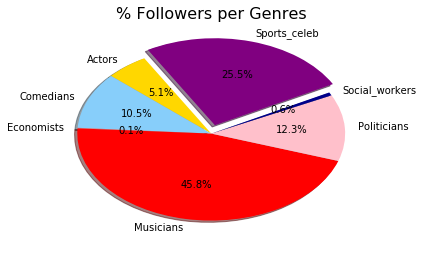

In [52]:
 ## TM - whole cell
# Labels for the sections of our pie chart
labels = AggregatedGenre['Genre']

# The values of each section of the pie chart
# sizes = Data_Influencers_DF.groupby(["Genere"],as_index=False).sum()["fare"].tolist()
sizes = AggregatedGenre['Followers']

# The colors of each section of the pie chart
colors = ["gold", "lightskyblue", "lightcoral",'red','pink','darkblue','purple']

# Tells matplotlib to seperate the "Python" section from the others
explode = (0,0,0,0,0,0,0.1)

# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=120)

# Tells matplotlib that we want a pie chart with equal axes
plt.axis("off")

  
plt.title("% Followers per Genres", fontsize=16)

plt.savefig('Images/% Followers per Genres.png')
# Prints our pie chart to the screen
plt.show()

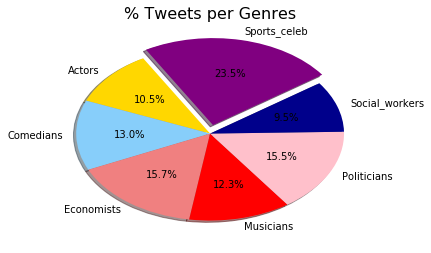

In [53]:
 ## TM - whole cell
# Labels for the sections of our pie chart
labels = AggregatedGenre['Genre']

# The values of each section of the pie chart
# sizes = Data_Influencers_DF.groupby(["Genere"],as_index=False).sum()["fare"].tolist()
sizes = AggregatedGenre['Tweets']

# The colors of each section of the pie chart
colors = ["gold", "lightskyblue", "lightcoral",'red','pink','darkblue','purple']

# Tells matplotlib to seperate the "Python" section from the others
explode = (0,0,0,0,0,0,0.1)

# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=120)

# Tells matplotlib that we want a pie chart with equal axes
plt.axis("off")

  
plt.title("% Tweets per Genres", fontsize=16)

plt.savefig('Images/% Tweets per Genres.png')
# Prints our pie chart to the screen
plt.show()

In [67]:
# -TM - People who are top ten Influencer who tweet more
top_ten_twitters = Data_Influencers_DF.sort_values(['Tweets'],ascending=False).head(10)
top_ten_twitters

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count,Average Tweets,Count
332,@Noahpinion,Noah,Smith,Economists,NA,Eng,04/14/2011,2636.0,140810.0,102285.0,811.0,211658.0,140810.0,0
359,@BDUTT,Barkha,Dutt,Social_workers,India,Eng,02/02/2009,3437.0,118522.0,6818183.0,1573.0,27895.0,118522.0,0
356,@ProfessorChic,Jamie,Mitchell,Social_workers,NA,Eng,04/04/2011,2646.0,79770.0,1455.0,572.0,24906.0,79770.0,0
339,@haroldpollack,Harold,Pollack,Economists,NA,Eng,12/25/2009,3111.0,65220.0,20535.0,2426.0,7087.0,65220.0,0
276,@CoryBooker,Cory,Booker,Politicians,"Newark, NJ",Eng,08/11/2008,3612.0,61946.0,4121450.0,93081.0,91.0,61946.0,0
325,@MarkThoma,Mark,Thoma,Economists,NA,Eng,10/18/2008,3544.0,60103.0,44687.0,417.0,5.0,60103.0,0
82,@iliza,Iliza,Shiesinger,Comedians,"Hollywood, CA",Eng,02/15/2009,3424.0,49168.0,170288.0,468.0,27094.0,49168.0,0
125,@IGGYAZALEA,Iggy,Azalea,Musicians,"California, USA",Eng,06/09/2010,2945.0,47711.0,8083827.0,6510.0,4226.0,47711.0,0
216,@criscyborg,Cris,Cyborg,Sports_celeb,cris.cyborg.llc@gmail.com,Eng,11/29/2009,3137.0,46474.0,191709.0,2134.0,12424.0,46474.0,0
352,@socworkpodcast,Jonathan,Singer,Social_workers,"Chicago, IL",Eng,09/09/2009,3218.0,45410.0,14240.0,793.0,22387.0,45410.0,0


In [68]:
# AggregatedGenre

In [69]:
#  -TM - Top ten Influencer who who have more Followers
top_ten_influencer = Data_Influencers_DF.sort_values(['Followers'],ascending=False).head(10)
top_ten_influencer

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count,Average Tweets,Count
91,@katyperry,Katy,Perry,Musicians,,Eng,02/20/2009,3418.0,9219.0,109571326.0,216.0,6214.0,9219.0,0
251,@BarackObama,Barack,Obama,Politicians,NA,Eng,03/05/2007,4136.0,15517.0,103450975.0,621134.0,11.0,15517.0,0
86,@taylorswift13,Taylor,Swift,Musicians,NA,Eng,12/06/2008,3495.0,100.0,85537021.0,0.0,458.0,100.0,0
95,@ladygaga,Lady,Gaga,Musicians,NA,Eng,03/26/2008,3749.0,8764.0,78891510.0,127022.0,1915.0,8764.0,0
66,@TheEllenShow,Ellen,DeGeneres,Comedians,California,Eng,08/14/2008,3609.0,16964.0,78048964.0,35733.0,954.0,16964.0,0
139,@Cristiano,Cristiano,Ronaldo,Sports_celeb,Madrid,NA,06/14/2010,2940.0,3212.0,74200676.0,99.0,0.0,3212.0,0
105,@jtimberlake,Justin,Timberlake,Musicians,"Memphis, TN",Eng,03/25/2009,3386.0,3975.0,66044385.0,282.0,192.0,3975.0,0
107,@BritneySpears,Britney,Spears,Musicians,NA,Eng,09/22/2008,3570.0,5474.0,58234803.0,386048.0,2554.0,5474.0,0
87,@ArianaGrande,Ariana,Grande,Musicians,ǝʌɐ uooɯʎǝuoɥ,Eng,04/23/2009,3357.0,41436.0,57668079.0,64056.0,34199.0,41436.0,0
122,@ddlovato,Demi,Lovato,Musicians,DALLAS/LA,Eng,02/17/2009,3422.0,17084.0,57271753.0,539.0,2098.0,17084.0,0


In [70]:
#--RR Still Working test cell
# to find the handle of followers of the top most 
# active Influencer so that we can send the tweet through a bot.
# top_ten_twitters.head(1)['Twitter_Handle'].map(lambda x: x.lstrip('@'))
# import time
# ids = []
# for page in tweepy.Cursor(api.followers_ids, top_ten_twitters.head(1)['Twitter_Handle'].map(lambda x: x.lstrip('@'))).pages():
#     ids.extend(page)
#     time.sleep(60)

# 2. Sentiment Analysis of the Influencers: 

In [71]:
# # -TM - Extract the first 1000 tweets of the Influencers
print("-----------Start extraction of the tweets posted by the Influencers!!!-----------")
Influencers = top_ten_influencer['Twitter_Handle']
Sentiment_array = []

for user in Influencers:
    # Set the tweet count to 100
    tweet_count = 1000
    print("Extracting tweets from %s"%user)
    
    # Extract tweets up to 5 pages
    for x in range(10):
        influencer_tweets = api.user_timeline(user,page = x)
# influencer_tweets        
        
        # For each tweet in a bunch of public tweets
        for tweet in influencer_tweets:
            
            #Calculate the compound, positive, negative and neutral values of each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            
            age_of_tweet = (datetime.now(timezone.utc) - datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y')).days
            tweetAge = 0 
            if age_of_tweet < 180:
                tweetAge = 1
            elif age_of_tweet < 365:   
                tweetAge = 2
            else:
                tweetAge = 3
            
 
            
            # Save the Tweets in an array as a dictionery item 
            Sentiment_array.append({"Influencers" : user,
                                    "Tweet Text" : tweet["text"],
                                    "Compound" : compound,
                                    "Positive" : pos,
                                    "Negative" : neg,
                                    "Neutral" : neu,
                                    "Date" : datetime.strptime(tweet["created_at"],'%a %b %d %H:%M:%S %z %Y').strftime('%m/%d/%Y'),
                                    "AgeOfTweet":age_of_tweet,
                                    "TweetAgeType":tweetAge,
                                    "Tweets Ago": tweet_count
                                   })
            
            #Decrease count of tweet by 1 in the reverse order
            tweet_count -= 1

print("-----------End of Extraction of Tweets !!!-----------")

-----------Start extraction of the tweets posted by the Influencers!!!-----------
Extracting tweets from @katyperry
Extracting tweets from @BarackObama
Extracting tweets from @taylorswift13
Extracting tweets from @ladygaga
Extracting tweets from @TheEllenShow
Extracting tweets from @Cristiano
Extracting tweets from @jtimberlake
Extracting tweets from @BritneySpears
Extracting tweets from @ArianaGrande
Extracting tweets from @ddlovato
-----------End of Extraction of Tweets !!!-----------


In [72]:
# # RR Sentiment_array
# Sentiment_array['TweetAge'] = 3

# Sentiment_array.loc[Sentiment_array['AgeOfTweet'] < 180, 'TweetAge'] = 1
# Sentiment_array.loc[Sentiment_array['AgeOfTweet'] > 180 & Sentiment_array['AgeOfTweet'] < 365, 'TweetAge'] = 2
# Sentiment_array

In [73]:
# -TM - whole Cell
# Create dataframe from the Dictionery item of the Sentiment Array
Sentiment_DF = pd.DataFrame.from_dict(Sentiment_array)

# -TM -Remove the '@' from the 'influence' column in the data frame
Sentiment_DF["Influencers"] = Sentiment_DF["Influencers"].map(lambda x: x.lstrip('@'))

# -TM - Re_arrang the columns and save into a CSV file
Sentiment_DF = Sentiment_DF[["Influencers", "Date", "Tweet Text"
                             , "Compound", "Positive", "Negative"
                             , "Neutral", "Tweets Ago","AgeOfTweet","TweetAgeType"
                            ]]

# -TM -Store output in a .CSV File
Sentiment_DF.to_csv("OutPut/influencer_Sentiment_tweets_Analysis.csv")

Sentiment_DF

,Influencers,Date,Tweet Text,Compound,Positive,Negative,Neutral,Tweets Ago,AgeOfTweet,TweetAgeType
0,katyperry,06/23/2018,Was so proud to give the gift of #transcendent...,0.8805,0.362,0.000,0.638,1000,9,1
1,katyperry,06/22/2018,found my first skin tag today. I think I’m an ...,0.0000,0.000,0.000,1.000,999,10,1
2,katyperry,06/21/2018,"Never forget, everyone was once a child.",0.1695,0.250,0.000,0.750,998,11,1
3,katyperry,06/20/2018,My Aussies 🐨 &amp; Kiwis 🥝! For the FINALE of ...,0.0000,0.000,0.000,1.000,997,12,1
4,katyperry,06/15/2018,"I 👁 you, @RoarForJess, and I ❤ you, and I’m si...",0.0000,0.000,0.000,1.000,996,17,1
5,katyperry,06/09/2018,Scandinavians have figured it out.,0.0000,0.000,0.000,1.000,995,22,1
6,katyperry,06/09/2018,Oi oi @JackGarratt remember when we locked our...,0.0000,0.000,0.000,1.000,994,23,1
7,katyperry,06/09/2018,WITNESS IS 1⃣❗🎂 🎈 https://t.co/fz83TjrJUr http...,0.0000,0.000,0.000,1.000,993,23,1
8,katyperry,06/06/2018,IM SCREAMINGOSBEJRMF$&amp;2@!K https://t.co/Sn...,0.0000,0.000,0.000,1.000,992,26,1
9,katyperry,06/05/2018,CALIFORNIANS! What’s important to you? Is it g...,-0.8821,0.072,0.445,0.483,991,27,1


In [74]:
# -TM -Get the unique list of the influencers
Influencers_array = Sentiment_DF["Influencers"].unique()
Influencers_array

array(['katyperry', 'BarackObama', 'taylorswift13', 'ladygaga',
       'TheEllenShow', 'Cristiano', 'jtimberlake', 'BritneySpears',
       'ArianaGrande', 'ddlovato'], dtype=object)

In [75]:
# -TM -Calculate the mean for each Influencers & store into a dataframe
Influencers_Comp_Mean = Sentiment_DF.groupby("Influencers").mean()["Compound"].to_frame()

#-TM -Reset the index 
Influencers_Comp_Mean.reset_index(inplace=True)

Influencers_Comp_Mean

,Influencers,Compound
0,ArianaGrande,0.200119
1,BarackObama,0.343343
2,BritneySpears,0.379596
3,Cristiano,0.222748
4,TheEllenShow,0.371899
5,ddlovato,0.207426
6,jtimberlake,0.213364
7,katyperry,0.185761
8,ladygaga,0.347224
9,taylorswift13,0.183432


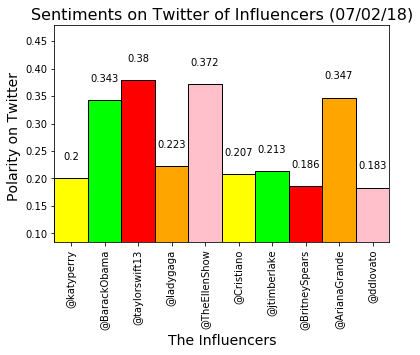

In [76]:
# -TM - Whole cell
# Set the values for x_axis & y_axis
x_axis = Influencers_Comp_Mean.index.values
y_axis = Influencers_Comp_Mean["Compound"]
X_Label = Influencers

# Intialize the plots. 
fig,ax = plt.subplots()#  function that returns a tuple containing a figure and axes object(s)

#Set the plot and assign the values like colors etc
bars = ax.bar(x_axis,y_axis
              , align = "edge"
              , width = 1
              , linewidth = 1
              , edgecolor = 'black'
              , color = ["yellow","lime","red","orange","pink"]
             )

# Set the tick(s) of the bar graph
tick_locations = [value + 0.5 for value in range(len(x_axis))]
plt.xticks(tick_locations,X_Label,rotation='vertical')

# If value is positive then put True in the Summary else place False
Influencers_Comp_Mean["Positive"] = Influencers_Comp_Mean["Compound"] > 0

# Assign the height based on positive value after allocating True / false value
height = Influencers_Comp_Mean.Positive.map({True: 0.03 , False: -0.03})

# # Set the value on labels on the bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + height[bars.index(bar)]
            , round(Influencers_Comp_Mean["Compound"][bars.index(bar)],3)
            , ha = 'center'
            , va = 'bottom'
            )

# Set the x_axis limits
ax.set_xlim(0, len(x_axis))

# Dynamically set the y_axis limits by finding the max & min value of y-axis
ax.set_ylim(min(y_axis)-0.1, max(y_axis) + 0.1)

# Set a horizontal line at y = 0
plt.hlines(0,0,len(x_axis))

# Title of the graph
ax.set_title("Sentiments on Twitter of Influencers (%s)" % (time.strftime("%x")), fontsize=16)

# Setting the y_axis label
ax.set_ylabel("Polarity on Twitter ", fontsize=14)

# # Setting the x_axis label
ax.set_xlabel("The Influencers", fontsize=14)
  
# Saving the graph
plt.savefig("Images/The Influencer Twitter Sentiment.png",bbox_inches='tight')
plt.show()

In [77]:
# WIP
# influencersDictionary = {}
# colors = ["yellow","lime","red","orange","pink","yellow","lime","red","orange","pink"]
# index = 0
# for person in Influencers:
#     influencersDictionary[person] = colors[index]
#     index+=1
# influencersDictionary

In [78]:
# # Create an array of Influencers Houses with the unique function in the data frame
# Influencers_array = Sentiment_DF["Influencers"].unique()
# Influencers_array

# # #Plotting the graph for each influencer
# for influencer in Influencers_array:
# # Creating a temporary data frame to store for only one influencer at a time
#         Temp_DF = Sentiment_DF[Sentiment_DF["influencer"] == influencer]
        
#         Sentiment_DF['influencer'] = Sentiment_DF['influencer'].map(lambda x: x.lstrip('@'))
# #Temp_DF
    
#         plt.scatter(Temp_DF["Tweets Ago"],Temp_DF["Compound"]
#                  , marker = "o", linewidth = 0, alpha = 0.8, label = Influencers
#                  , facecolors = Temp_DF.influencer.map(influencersDictionary)
#                 )

# # # Set the legend 
# plt.legend(bbox_to_anchor = (1,1), title="The Influencers", loc='best')

# # # Set the labels of x_axis, y_axis & title 
# plt.xlabel("Tweets Ago", fontsize=12)
# plt.ylabel("Tweet Polarity", fontsize=12)
# plt.title("Sentiment Analysis of The Influencers Tweets (%s)" % (time.strftime("%x")), fontsize=16)

# # #Set the limite of  x_axis and y_axis
# plt.xlim(0, 101)
# plt.ylim(-1,1)

# # # Set the grid
# plt.grid(True)

# filePath = 'Images'
# if not path.exists(filePath):
#     makedirs(filePath)

# # Save the result to a .png file
# plt.savefig("Sentiment Analysis of Influencers Tweets.png",bbox_inches='tight')
# # plt.savefig("Sentiment Analysis of The influencer's Tweets.png",bbox_inches='tight')

# plt.show()

In [ ]:
# Version: 1.01
# Date: Mon July 2nd, 2018 
# Time: 6:00 PM
# Functionalities: 
# A) Data Analysis
#     1. Created dataframe.
#     2. Sorting
# B) Sentiment Analysis

# WIP (Work in progress)
# 1. Tweet bot. The git part is done. 
# Automation is pending as hosting might need neet tech which we have not covered now.

# Pending items:
# 1. Data Cleaning
# 2. Graphs and plots
# 3. Testing